In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import espra, smooth, robust_smooth, tangential_velocity, fit_psi_params, psi_params, normalize_matrix, calc_ow


### Satellite Data

In [2]:
ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_copernicus_CCE_2023_1D_3000m.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

z_ssh = ssh_dataset['depth'][:].data
lon_ssh, lat_ssh = ssh_dataset['longitude'][:].data, ssh_dataset['latitude'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh, indexing='ij')
u_ssh, v_ssh = ssh_dataset['uo'][:].data, ssh_dataset['vo'][:].data
u_ssh, v_ssh = np.transpose(u_ssh, axes=(3,2,1,0)), np.transpose(v_ssh, axes=(3,2,1,0)) # LON, LAT, DEPTH, TIME
tim_ssh = ssh_dataset['time'][:].data # Hours Since 1950-01-01

ref_date = pd.Timestamp("1950-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="h")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,:,t], v_ssh[:,:,:,t]
    ut = np.where(np.abs(ut) < 100, ut, np.nan)
    vt = np.where(np.abs(vt) < 100, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


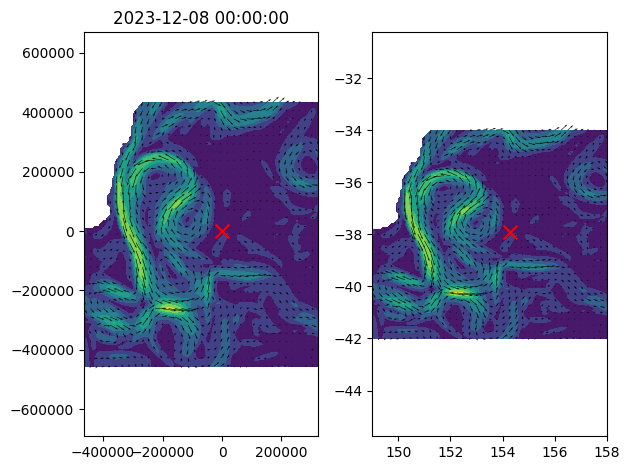

In [3]:
t_idx = 50
z_idx = 0
time = list(dic_ssh_data.keys())[t_idx]
dic = dic_ssh_data[time]
ut, vt = dic['u'][:,:,z_idx], dic['v'][:,:,z_idx]

fig, axs = plt.subplots(1, 2)

axs[0].contourf(x_ssh, y_ssh, np.hypot(ut, vt))
spac = 3
axs[0].quiver(x_ssh[::spac, ::spac], y_ssh[::spac, ::spac],
           ut[::spac, ::spac], vt[::spac, ::spac])
axs[0].scatter(0,0, marker='x', color='r', s=100)
axs[0].axis('equal'); axs[0].set_title(time)

axs[1].contourf(lon_ssh, lat_ssh, np.hypot(ut, vt))
spac = 3
axs[1].quiver(lon_ssh[::spac, ::spac], lat_ssh[::spac, ::spac],
           ut[::spac, ::spac], vt[::spac, ::spac])
axs[1].scatter(theta_mean, phi_mean, marker='x', color='r', s=100)
axs[1].axis('equal'); axs[0].set_title(time)
# axs[1].set_xlim(152, 156); axs[1].set_ylim(-39, -36);

plt.tight_layout()


,xc,yc,w,Q,Rc,psi0,A,r2_1,r2_2,Time,sxc,syc,sq11,sq12,sq22,sRc,spsi0,sA,sw
0,-5802.908374,-1563.771988,-0.000037,"[[1.0301643105849614, -0.08332720822216222], [...",78861.347625,59216.325164,-0.000010,0.992436,0.508325,2023-10-19 00:00:00,-6559.996928,-2108.042418,0.972914,-0.103055,1.041144,78310.494156,58665.238689,-0.000010,-0.000039
1,-4981.140748,-26.429374,-0.000036,"[[0.9631693575540718, -0.10730452108581083], [...",74284.784695,55352.233891,-0.000010,0.989580,0.638865,2023-10-19 23:56:15,-5957.125554,-2721.266111,0.947328,-0.107706,1.072288,77591.662334,58227.482213,-0.000010,-0.000039
2,-8885.799690,-4721.730306,-0.000037,"[[0.9255072352056705, -0.1185051228863016], [-...",81765.918632,61411.418868,-0.000009,0.990015,0.416612,2023-10-21 00:00:00,-4982.241927,-3128.339941,0.921162,-0.099094,1.103794,77029.587309,57822.293379,-0.000010,-0.000040
3,-4142.215128,-4567.341615,-0.000038,"[[0.870303241417468, -0.12170574479314025], [-...",75427.659487,56909.640918,-0.000010,0.993006,0.615588,2023-10-22 00:00:00,-4844.532664,-4053.698867,0.872769,-0.075292,1.162368,76394.550769,57566.706402,-0.000010,-0.000040
4,-1078.521019,-4746.479963,-0.000038,"[[0.8168376219820783, -0.06486040912522494], [...",74786.457686,56201.598766,-0.000010,0.992719,0.717521,2023-10-22 23:56:15,-3976.298927,-5278.160402,0.844242,-0.025686,1.200961,76931.027250,58427.447786,-0.000010,-0.000040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,-297737.567092,156754.359903,-0.000020,"[[0.8470330042814647, 0.00846037253683076], [0...",56646.751809,21134.427455,-0.000007,0.933604,0.262075,2024-01-31 00:00:00,-296413.616796,158109.922928,0.964885,-0.016146,1.192523,60455.785902,22783.443503,-0.000006,-0.000027
105,-298005.530824,156269.898688,-0.000021,"[[0.8973369092907337, 0.2778837355453176], [0....",54365.300180,19922.101692,-0.000007,0.913641,0.323641,2024-02-01 00:00:00,-300358.646014,157995.891402,1.266966,0.140124,1.049442,68777.418383,23769.083165,-0.000005,-0.000025
106,-300565.349212,165500.883450,-0.000022,"[[1.3276634948890262, 0.4330534110361884], [0....",64759.956181,25175.325927,-0.000006,0.947802,0.305300,2024-02-02 00:00:00,-303216.816171,157985.201138,1.725450,0.283161,0.819035,76765.802115,26696.517854,-0.000005,-0.000026
107,-308726.488912,154030.512188,-0.000024,"[[2.4882099130928554, 0.389587848686837], [0.3...",100666.522244,28491.253823,-0.000003,0.941040,-0.082056,2024-02-02 23:56:15,-304583.061221,158292.110118,1.944483,0.351657,0.728860,81782.466352,28083.419301,-0.000005,-0.000025


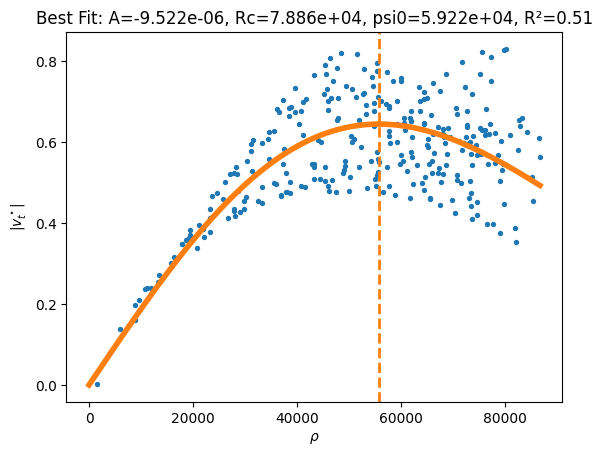

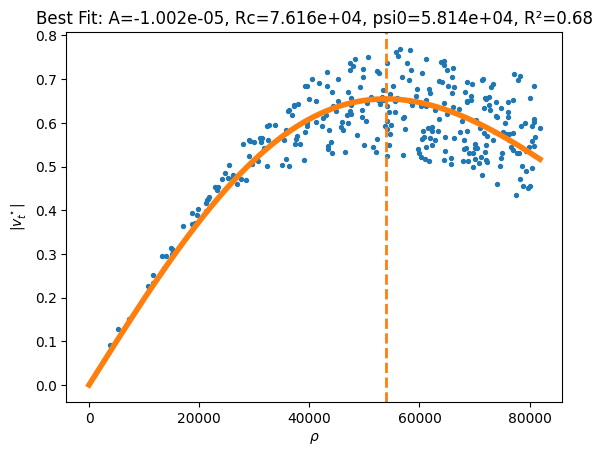

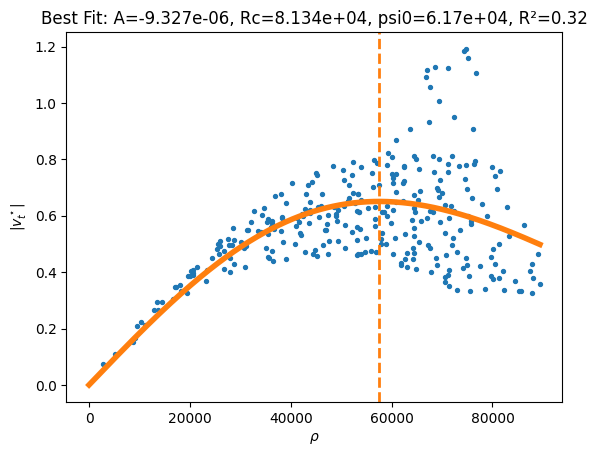

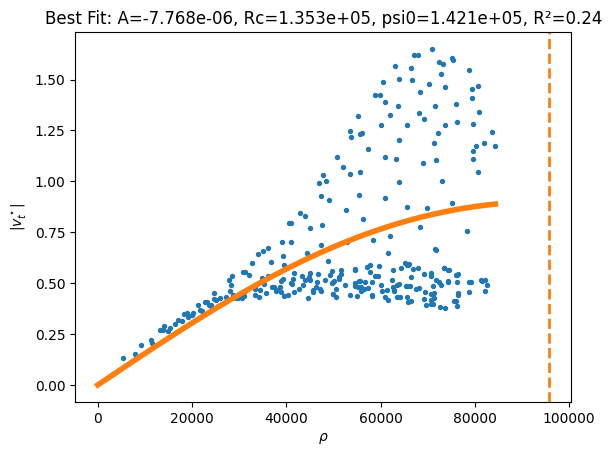

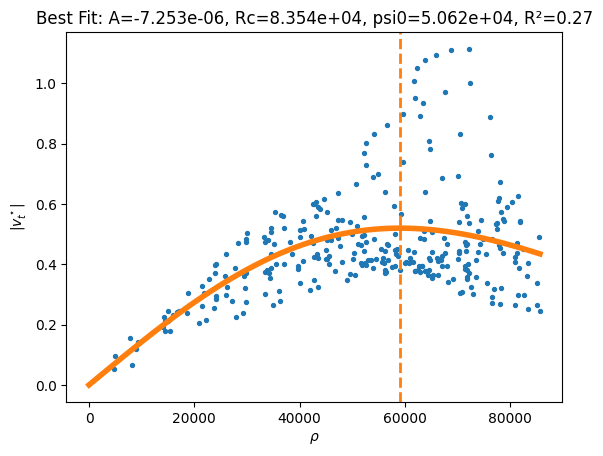

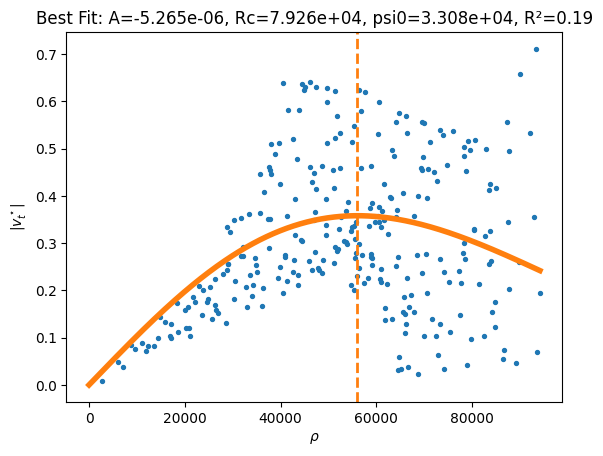

In [4]:
xc_pre, yc_pre = 0, 0
q11_pre, q12_pre, q22_pre = 1, 0, 1
df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'r2_1', 'r2_2', 'Time'])
rho_core_thresh = 30000
rho_outer_core_thresh = 80000
dic_params = {}
for k, t_idx in enumerate(range(len(dic_ssh_data))):
    time = list(dic_ssh_data.keys())[t_idx]
    dic = dic_ssh_data[time]
    ut, vt = dic['u'][:,:,0], dic['v'][:,:,0]

    dx, dy = x_ssh - xc_pre, y_ssh - yc_pre
    rho_search = np.sqrt(q11_pre*dx**2 + 2*q12_pre*dx*dy + q22_pre*dy**2)
    mask_core = rho_search < rho_core_thresh
    xi, yi, ui, vi = x_ssh[mask_core], y_ssh[mask_core], ut[mask_core], vt[mask_core]
    xc, yc, w, Q, _, _, A0, r2_1, _ = espra(xi, yi, ui, vi, Rc_max=150000, r2_flag=True)
    # All
    mask_outer = rho_search < rho_outer_core_thresh
    axi, ayi, aui, avi = x_ssh[mask_outer], y_ssh[mask_outer], ut[mask_outer], vt[mask_outer]

    if (np.hypot(xc-xc_pre, yc-yc_pre)<100000) & (np.sign(w)<0):

        df = psi_params(xc, yc, Q, axi, ayi, aui, avi)
        df = df[df.vt < 0]
        Rc, psi0, A, r2_2 = fit_psi_params(df.rho2, df.Qr, df.vt, A0=A0,
                                           Rc_max=150000, plot=True if k%20==0 else False, r2_flag=True)
        
        if A >= 0:
            Rc, psi0, A, r2_2 = np.nan, np.nan, np.nan, np.nan
        df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q,
                                   'Rc': Rc, 'psi0': psi0, 'A': A,
                                   'r2_1': r2_1, 'r2_2': r2_2, 'Time': time}
        xc_pre, yc_pre = xc, yc
        q11_pre, q12_pre, q22_pre = Q[0,0], Q[1,0], Q[1,1]
        # Gather data for better psi param fit
        dic_params[time] = psi_params(xc, yc, Q, axi, ayi, aui, avi)
    else:
        break

wdw = 5
df_res['sxc'] = smooth(df_res.xc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Time, window=wdw, num=len(df_res)) 

df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['spsi0'] = smooth(df_res.psi0, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A, df_res.Time, window=wdw, num=len(df_res)) 

df_res['sw'] = 2*df_res.sA*(df_res.sq11 + df_res.sq22)

df_res


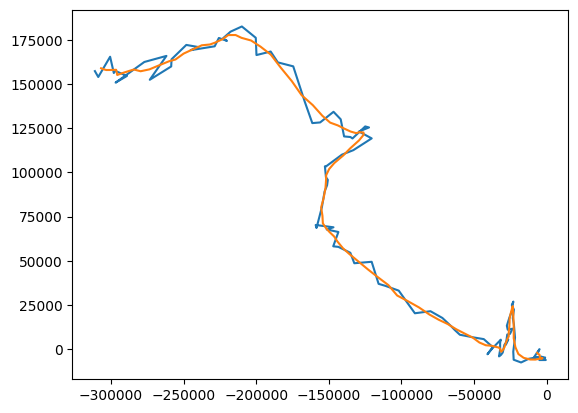

In [5]:
plt.plot(df_res.xc, df_res.yc)
plt.plot(df_res.sxc, df_res.syc)


In [6]:
dic_k = {}

for t in range(len(df_res)):
    surf = df_res.iloc[t]
    ut, vt = dic_ssh_data[surf.Time]['u'], dic_ssh_data[surf.Time]['v']

    xc_pre, yc_pre = surf.sxc, surf.syc
    q11_pre, q12_pre, q22_pre = surf.sq11, surf.sq12, surf.sq22

    rows = [{
        'xc': surf.sxc, 'yc': surf.syc, 'w': surf.sw,
        'q11': surf.sq11, 'q12': surf.sq12, 'q22': surf.sq22,
        'Rc': surf.sRc, 'psi0': surf.spsi0, 'A': surf.sA,
        'r2_1': surf.r2_1, 'r2_2': surf.r2_2, 'Depth': z_ssh[0]
    }]

    for k in range(1, ut.shape[-1]):
        utk, vtk = ut[:, :, k], vt[:, :, k]

        dx, dy = x_ssh - xc_pre, y_ssh - yc_pre 
        rho_search = np.sqrt(q11_pre*dx**2 + 2*q12_pre*dx*dy + q22_pre*dy**2)
        mask_core = rho_search < rho_core_thresh

        if not np.any(mask_core):
            continue

        xi, yi = x_ssh[mask_core], y_ssh[mask_core]
        ui, vi = utk[mask_core], vtk[mask_core]
        xc, yc, w, Q, Rc, psi0, A, r2_1, r2_2 = espra(xi, yi, ui, vi, Rc_max=150000, r2_flag=True)

        # All
        mask_outer = rho_search < rho_outer_core_thresh
        axi, ayi, aui, avi = x_ssh[mask_outer], y_ssh[mask_outer], utk[mask_outer], vtk[mask_outer]

        if (np.hypot(xc - xc_pre, yc - yc_pre) < 100000) and (w < 0) and (A < 0):

            df = psi_params(xc, yc, Q, axi, ayi, aui, avi)
            df = df[df.vt < 0]
            Rc, psi0, A, r2_2 = fit_psi_params(df.rho2, df.Qr, df.vt, A0=A0,
                                               Rc_max=150000, r2_flag=True)
            if A >= 0:
                Rc, psi0, A, r2_2 = np.nan, np.nan, np.nan, np.nan

            q11, q12, q22 = Q[0, 0], Q[1, 0], Q[1, 1]
            rows.append({'xc': xc, 'yc': yc, 'w': w, 'q11': q11, 'q12': q12, 'q22': q22,
                         'Rc': Rc, 'psi0': psi0, 'A': A, 'r2_1': r2_1, 'r2_2': r2_2, 'Depth': z_ssh[k]})
            xc_pre, yc_pre = xc, yc
            q11_pre, q12_pre, q22_pre = q11, q12, q22

    df_res_k = pd.DataFrame(rows, columns=['xc','yc','w','q11','q12','q22','Rc','psi0','A','r2_1','r2_2', 'Depth'])
    dic_k[surf.Time] = df_res_k


/scratch/pbs.7091950.kman.restech.unsw.edu.au/ipykernel_3604808/2350175541.py:21: RuntimeWarning: invalid value encountered in sqrt
  rho_search = np.sqrt(q11_pre*dx**2 + 2*q12_pre*dx*dy + q22_pre*dy**2)
/home/z5297792/UNSW-MRes/MRes/modules/utils.py:517: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(vt_model, rho2, vt, p0=[A0, Rc0],


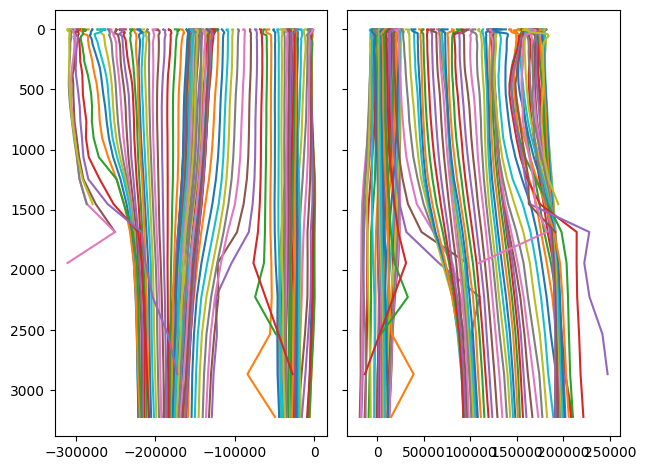

In [7]:
fig, axs = plt.subplots(1, 2, sharey=True)
for t_idx in range(len(dic_k)):
    time = list(dic_k.keys())[t_idx]
    df = dic_k[time]
    axs[0].plot(df.xc, df.Depth)
    axs[1].plot(df.yc, df.Depth)
axs[0].invert_yaxis()
plt.tight_layout()
    

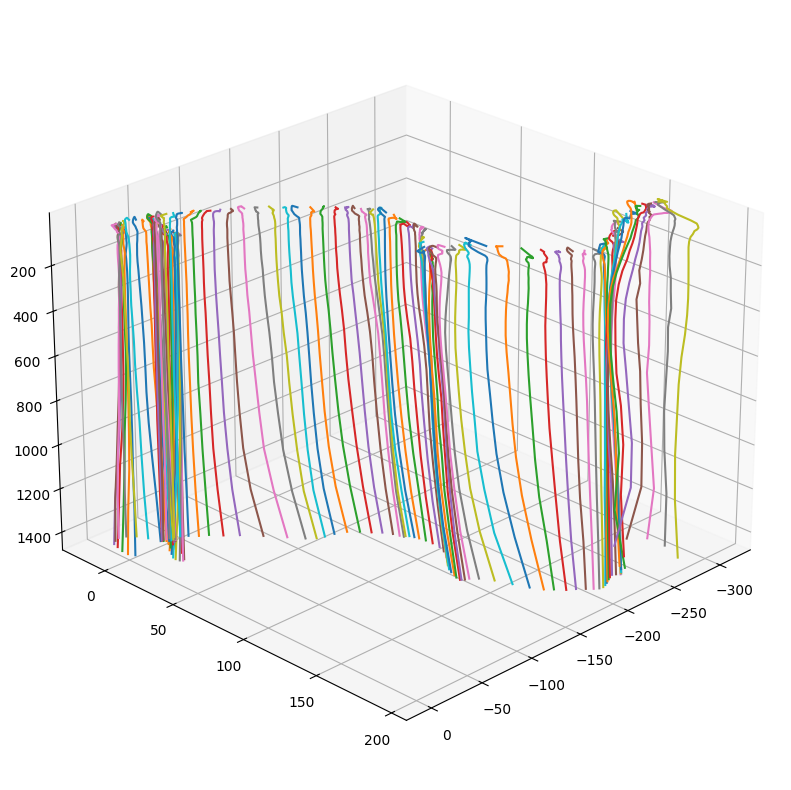

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for time, df in dic_k.items():
    df_m = df.copy()
    df_m = df_m[df_m.Depth < 1500]
    ax.plot(df_m.xc/1e3, df_m.yc/1e3, df_m.Depth)

ax.view_init(elev=25, azim=45)

ax.invert_zaxis()


In [9]:
X, Y = x_ssh, y_ssh

U = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))
OW = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))

for t_idx in range(len(dic_k)):
    time = list(dic_k.keys())[t_idx]
    df = dic_k[time]

    for k in range(len(df)):
        data = df.iloc[k]
        dx, dy = X - data.xc, Y - data.yc
        rho2 = data.q11*dx**2 + 2*data.q12*dx*dy + data.q22*dy**2
    
        U[:,:,k,t_idx] = - data.A * np.exp( - rho2 / data.Rc**2 ) * ( 2*data.q12*dx + 2*data.q22*dy )
        V[:,:,k,t_idx] =   data.A * np.exp( - rho2 / data.Rc**2 ) * ( 2*data.q11*dx + 2*data.q12*dy ) 

        OW[:,:,k,t_idx] = calc_ow(U[:,:,k,t_idx].T, V[:,:,k,t_idx].T, X[1,0] - X[0,0], Y[0,1] - Y[0,0]).T
    OW[:,:,:,t_idx] = normalize_matrix(OW[:,:,:,t_idx])



(np.float64(-467868.1264979113),
 np.float64(327725.45653936424),
 np.float64(-459725.141143799),
 np.float64(437524.9294281004))

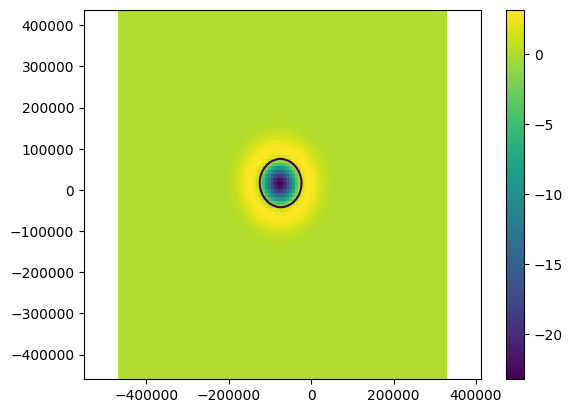

In [10]:
plt.pcolor(X, Y, OW[:,:,0,44])
plt.colorbar()
plt.contour(X, Y, OW[:,:,0,44], levels=[-0.2])
plt.axis('equal')


In [11]:
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# from skimage import measure

# for t_idx in range(len(dic_k)):
#     if t_idx not in [41, 42, 43]:
#         time = list(dic_k.keys())[t_idx]
#         df_t = dic_k[time].copy().sort_values('Depth')
        
#         depth_new = np.arange(df_t['Depth'].min(), df_t['Depth'].max() + 50, 50)
#         idx = pd.Index(np.union1d(df_t['Depth'].to_numpy(), depth_new))
#         df = (df_t.set_index('Depth')
#                   .reindex(idx)
#                   .interpolate(method='index', limit_area='inside')
#                   .loc[depth_new]
#                   .reset_index()
#                   .rename(columns={'index': 'Depth'}))
        
#         z = df.Depth
#         dz = z[1] - z[0]
#         dx, dy = (X[1,0]-X[0,0])/1e3, (Y[0,1]-Y[0,0])/1e3
        
#         verts, faces, normals, values = measure.marching_cubes(OW[:,:,:,t_idx], level=-0.2, spacing=(dx, dy, dz))
#         verts[:,0] += X.min()/1e3
#         verts[:,1] += Y.min()/1e3
#         verts[:,2] += z.min()
        
#         fig = plt.figure(figsize=(10,8))
#         ax = fig.add_subplot(111, projection='3d')
        
#         mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='none', label=r'$\sigma_{\text{OW}}=-0.2$')
#         mesh.set_zsort('min')
#         ax.add_collection3d(mesh)
        
#         ax.set_xlim(X.min()/1e3, X.max()/1e3)
#         ax.set_ylim(Y.min()/1e3, Y.max()/1e3)
#         ax.set_zlim(0, 3000)# z.max())
        
#         ax.plot(df.xc/1e3, df.yc/1e3, df.Depth, color='k', lw=2, label='Center Line')
#         ax.plot(np.nan, np.nan, np.nan, color='r', label=r'Max $v_t$')
        
#         ax.invert_zaxis()
#         ax.set_box_aspect((.1, .1, .09))
#         ax.view_init(elev=25, azim=45)
#         ax.set_xlabel('x (km)')
#         ax.set_ylabel('y (km)')
#         ax.set_zlabel('Depth (m)')
#         # ax.legend()
        
#         fig.suptitle(f'{time}')
#         plt.savefig(f'/srv/scratch/z5297792/ESP_Paper_Data/ESPRA_sat_data/3D_OW_isobath_plots/frame_{t_idx:03d}.png', dpi=300, bbox_inches='tight')
#         plt.close()
